In [1]:
# !pip install sciann fteikpy pyDOE -q 

In [2]:
import time
import os

In [3]:
ROOT_PATH = "EnDeepONet-OpenFWI"
if os.path.exists(ROOT_PATH):
    if input('overwirete? (y/n)') == 'y':
        os.system(f'rm -rf {ROOT_PATH}')
    else:
        raise ValueError('Please change ROOT_PATH')
os.system(f'mkdir {ROOT_PATH}')

0

In [4]:
RECEIVER_SIZE = 30
SENSOR_SIZE = 14*14
SOURCE_RADI = 0.
VMIN = 0.2
VMAX = 8.0
EPOCHS_MAX = 20000

In [5]:
import os
import numpy as np
import sciann as sn 

import itertools
from functools import partial
# from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline

---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.4 
Python Version: 3.8.16 (default, Jan 17 2023, 23:13:24) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

2023-05-20 07:09:36.719432: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 07:09:36.777628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 07:09:36.785080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 07:09:36.785741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

'/device:GPU:0'

In [7]:
# Download OpenFWI dataset to your local directory
# https://drive.google.com/drive/folders/1QTDno4_qed94mqhxJRzqWC19iYfANRqD
vel_models_path = "/Path/TO/CurveFault_B/"
vel_models_list = list(filter(lambda x: x.startswith('vel'), sorted(os.listdir(vel_models_path))))
vel_models = np.load(os.path.join(vel_models_path, vel_models_list[0])) / 1000

In [8]:
vel_models.shape

(500, 1, 70, 70)

In [9]:
INDEXING = 'ij'

In [10]:
DL = 0.050 #km
XMIN, XMAX = 0, 70*DL
YMIN, YMAX = 0, 70*DL
DELTAX = XMAX - XMIN
DELTAY = YMAX - YMIN

In [11]:
XGRID, YGRID = np.meshgrid(np.linspace(XMIN, XMAX, 70),
                           np.linspace(YMIN, YMAX, 70),
                           indexing=INDEXING)

def interpolate_velocity_model(Vs, Xs, Ys, method='nearest'):
    crd = np.hstack([XGRID.reshape(-1,1), YGRID.reshape(-1,1)])
    Vs = griddata(crd, Vs.flatten(), (Xs, Ys), method=method)
    return Vs.reshape(Xs.shape)

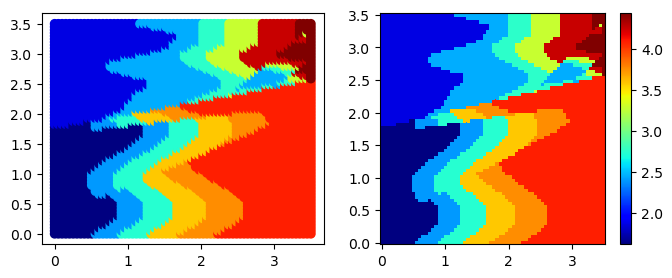

In [12]:
xgrid, ygrid = np.meshgrid(np.linspace(XMIN, XMAX, 70),
                           np.linspace(YMIN, YMAX, 70),
                           indexing=INDEXING)

vgrid = interpolate_velocity_model(vel_models[0, 0], xgrid, ygrid, 'nearest') #[:, ::-1]


fig, ax = plt.subplots(1,2,figsize=(8, 3))
ax[0].scatter(xgrid.flatten(), ygrid.flatten(), c=vel_models[0, 0].flatten(), cmap='jet')
# ax[0].invert_yaxis()
plt.colorbar(
    ax[1].pcolor(XGRID, YGRID, vel_models[0, 0], cmap='jet')
    # ax[1].imshow(vel_models[0, 0], cmap='seismic')
)
# ax[1].invert_yaxis()
# ax[1].invert_xaxis()
plt.show()

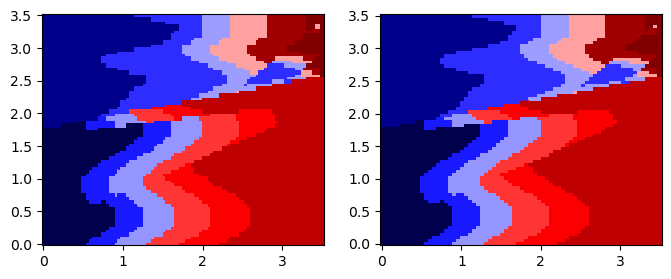

In [13]:
xgrid, ygrid = np.meshgrid(np.linspace(XMIN, XMAX, 100),
                           np.linspace(YMIN, YMAX, 100),
                           indexing=INDEXING)

vgrid = interpolate_velocity_model(vel_models[0, 0], xgrid, ygrid, 'nearest')

fig, ax = plt.subplots(1,2,figsize=(8, 3))
ax[0].pcolor(xgrid, ygrid, vgrid, cmap='seismic')
# ax[0].invert_yaxis()
ax[1].pcolor(XGRID, YGRID, vel_models[0, 0], cmap='seismic')
plt.show()

# Testing different velocity models 

In [14]:
import skfmm
from scipy.interpolate import griddata

class EikonalSolver:
    def __init__(self, xd = [-1.0, 1.0],
                       yd = [-1.0, 1.0],
                       vel = np.ones((10, 10)),
                       source = [0.0, 0.0]):
        self.origin = (xd[0], yd[0])
        Nx, Ny = [n - 1 for n in vel.shape]
        dx, dy = (xd[1]-xd[0])/(Nx), \
                 (yd[1]-yd[0])/(Ny)
        sx, sy = np.round((source[0] - xd[0])/dx).astype(int), \
                 np.round((source[1] - yd[0])/dy).astype(int)
        phi = np.ones_like(vel)
        phi[sx, sy] = -1
        self.nx = (Nx+1, Ny+1)
        self.xg = np.meshgrid(np.linspace(xd[0], xd[1], Nx+1),
                              np.linspace(yd[0], yd[1], Ny+1),
                              indexing=INDEXING)
        self.dx = (dx, dy)
        self.vg = vel
        self.Tg = skfmm.travel_time(phi,vel,dx=(dx, dy),order=2)
        
    def __call__(self, xs=0., ys=0.):
        crd = np.hstack([self.xg[0].reshape(-1,1), self.xg[1].reshape(-1,1)])
        ts = griddata(crd, self.Tg.flatten(), (xs, ys), method='nearest')
        return ts.reshape(xs.shape)
    
    @property
    def grid(self):
        return self.Tg
    
    @property
    def grad(self):
        Tx, Ty = np.gradient(self.Tg)
        return (Tx/self.dx[0], Ty/self.dx[1])
  

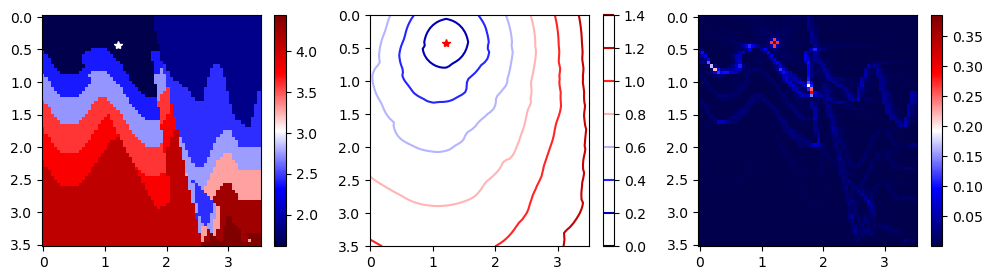

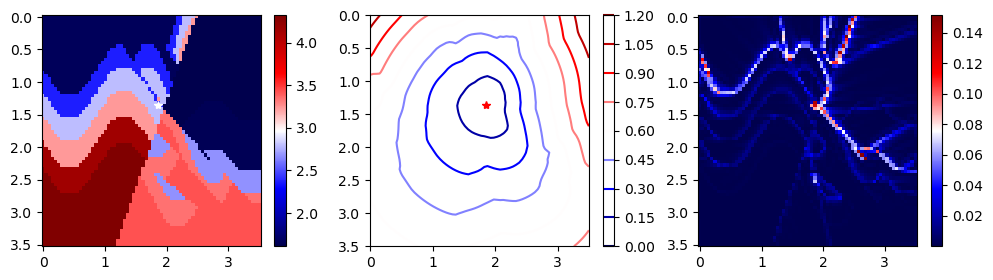

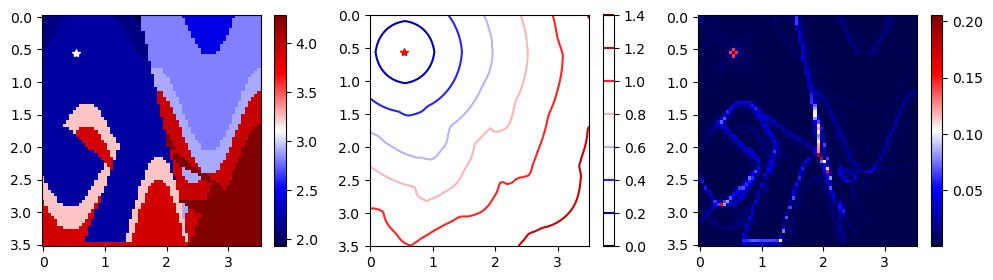

In [16]:

for i in range(3):
    v = vel_models[i, 0]
    xs = np.random.uniform(XMIN+0.1*DELTAX, XMAX-0.1*DELTAX)
    ys = np.random.uniform(YMIN+0.1*DELTAY, YMAX-0.1*DELTAY)
    
    eik = EikonalSolver(vel=v, xd=[XMIN, XMAX], yd=[YMIN, YMAX], source=[xs, ys])
    t = eik.grid
    x, y = eik.xg
    gt = eik.grad 
    res = abs(gt[0]**2 + gt[1]**2 - 1/v**2)

    fig, ax = plt.subplots(1,3,figsize=(12,3))
    plt.colorbar(
        ax[0].pcolor(x, y, v.T, cmap='seismic'), ax=ax[0]
    )
    ax[0].plot(ys, xs, '*w')
    plt.colorbar(
        ax[1].contour(x, y, t.T, cmap='seismic'), ax=ax[1]
    )
    ax[1].plot(ys, xs, '*r')
    plt.colorbar(
        ax[2].pcolor(x, y, res.T, cmap='seismic'), ax=ax[2]
    )
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[2].invert_yaxis()
    plt.show()

In [17]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [18]:
from tensorflow.keras.utils import Sequence 
from collections import OrderedDict


class DataGenerator(Sequence):
    def __init__(self, num_sample = 100,
                       sample_size = 10, 
                       batch_size = dict(data=1000, domain=1000, bc=100),
                       sensor_size = 10,
                       recevier_size = 10,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._num_sample = num_sample
        self._sample_size = sample_size
        self._batch_size = batch_size
        
        self._sensor_size = sensor_size
        sensor_size_1d = int(np.sqrt(self._sensor_size) + 0.001)
        grid_1d_x = np.linspace(XMIN, XMAX, sensor_size_1d + 2)[1:-1]
        grid_1d_y = np.linspace(YMIN, YMAX, sensor_size_1d + 2)[1:-1]
        self._sensor = [gi.flatten() for gi in np.meshgrid(grid_1d_x, grid_1d_y)]
        
        self._recevier_size = recevier_size
        self._receiver = [np.linspace(XMIN, XMAX, recevier_size+2)[1:-1], 
                          np.full(recevier_size, YMAX)]
        
        self._shuffle = shuffle
        self._epoch = 1
        self._time = time.time()
        self._velocity_ids = np.arange(0, num_sample, dtype=int)
        # self._velocity_ids = np.random.choice(len(vel_models), sample_size, replace=False)
        self._vel_ratio = 1.0
        self._set_data()
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return int((self._num_sample - 1) / self._sample_size) + 1

    def __getitem__(self, index):
        start = index * self._sample_size
        end = min(start + self._sample_size, self._num_sample)
        idx = np.hstack(self._sample_ids[start:end])
        inputs = [xs[idx] for xs in self.inputs]
        outputs = [ys[idx] for ys in self.targets]
        sample_weights = [ws[idx] for ws in self.sample_weights]
        return inputs, outputs, sample_weights

    def get_sample(self, index):
        idx = self._sample_ids[index]
        inputs = [xs[idx] for xs in self.inputs]
        outputs = [ys[idx] for ys in self.targets]
        sample_weights = [ws[idx] for ws in self.sample_weights]
        return inputs, outputs, sample_weights
    
    def on_epoch_end(self):
        if self._epoch % 100 == 0:
            # self._vel_ratio = min(1, self._vel_ratio + 0.01)
            print(f"{self._epoch} - {self._time - time.time()}s - data updated with vel-ratio = {self._vel_ratio} ")
            # self._set_data()
        if self._shuffle:
            np.random.shuffle(self._sample_ids)
        self._epoch += 1

    def _set_data(self):
        num_sample, batch_size = self._num_sample, self._batch_size
        inputs = OrderedDict()
        targets = OrderedDict()
        sample_weights = OrderedDict()
        sample_ids = []
        total_sample_size = 0
        for i, idx in enumerate(self._velocity_ids):
            x_source = np.random.uniform(XMIN+0.15*DELTAX, XMAX-0.15*DELTAX)
            y_source = np.random.uniform(YMIN+0.15*DELTAY, YMAX-0.15*DELTAY)
            sample_velocity = vel_models[idx, 0]
            # scheduled_velocity = (sample_velocity - sample_velocity.mean()) * self._vel_ratio + sample_velocity.mean()
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(
                x_source, y_source, sample_velocity, batch_size)
            num_sample_i = inputs_i[0].shape[0]
            for i_xs, xs in enumerate(inputs_i):
                if i_xs not in inputs:
                    inputs[i_xs] = []
                inputs[i_xs].append(xs)
            for i_ys, ys in enumerate(targets_i):
                if i_ys not in targets:
                    targets[i_ys] = []
                targets[i_ys].append(ys)
            for i_ws, ws in enumerate(sample_weights_i):
                if i_ws not in sample_weights:
                    sample_weights[i_ws] = []
                sample_weights[i_ws].append(ws)
            sample_ids.append(np.arange(num_sample_i).astype(int) + total_sample_size)
            total_sample_size = total_sample_size + num_sample_i
        # concat data
        self.inputs = [np.vstack(inputs[k]) for k in inputs]
        self.targets = [np.vstack(targets[k]) for k in targets]
        self.sample_weights = [np.hstack(sample_weights[k]) for k in sample_weights]
        self._sample_ids = sample_ids

    def __generate_batch_data(self, x_source, y_source, velocity, batch_size):
        counter = 0
        
        # eikonal (travel-time) solution
        eik2d = EikonalSolver(vel=velocity, xd=[XMIN, XMAX], yd=[YMIN, YMAX], source=[x_source, y_source])
        x_grid, y_grid = eik2d.xg
        
        # sample data
        if batch_size['data'] == 'all':
            ids_data = np.arange(0, x_grid.size, dtype=int)
        else:
            ids_data = np.random.choice(x_grid.size, batch_size['data'], replace=False)
        x_data, y_data = x_grid.flatten()[ids_data], y_grid.flatten()[ids_data]
        target_data = eik2d.grid.flatten()[ids_data]
        ids_data = np.arange(ids_data.size) + counter
        counter += ids_data.size

        # sample bc
        DELTAX = XMAX - XMIN
        DELTAY = YMAX - YMIN
        x_bc, y_bc = lhs_uniform(2, batch_size['bc'], 
                                 [[x_source - 1e-6, x_source + 1e-6], 
                                  [y_source - 1e-6, y_source + 1e-6]])
        target_bc = np.zeros_like(x_bc)
        ids_bc = np.arange(batch_size['bc']) + counter
        counter += ids_bc.size

        # contact data
        x_data = np.hstack([x_data, x_bc]).flatten()
        y_data = np.hstack([y_data, y_bc]).flatten()
        target_data = np.hstack([target_data, target_bc])
        ids_data = np.hstack([ids_data, ids_bc]).flatten()
        
        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_data]).reshape(-1,1)
        y_trunk = np.hstack([y_data]).reshape(-1,1)
        
        # - BRANCH -
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = interpolate_velocity_model(velocity, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        targets, sample_weights = [], []
        for idx, tg in zip([ids_data],
                           [target_data]):
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            ti = np.zeros((size_sample, ))
            if isinstance(tg, np.ndarray):
                ti[idx] = tg
            targets.append(ti.reshape(-1,1))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Vs, Nx=100, Ny=100, sensor_size=10, noise=0.0):
        counter = 0
        
        # eikonal solution
        eik2d = EikonalSolver(vel=Vs, xd=[XMIN, XMAX], yd=[YMIN, YMAX], source=[Xs, Ys])
        x_grid, y_grid = eik2d.xg
        t_grid = eik2d.grid
        
        # sample domain
        x_trunk, y_trunk = x_grid.reshape(-1,1), y_grid.reshape(-1,1)
        v_trunk = Vs.reshape(-1,1)
        target = t_grid.reshape(-1,1)
        size_sample = Nx*Ny
        
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = interpolate_velocity_model(Vs, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        
        if noise > 0:
            t_receiver += noise*np.std(t_receiver)*np.random.normal(0, 1, t_receiver.shape)
            t_receiver = np.maximum(0, t_receiver)
            
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        
        return inputs, v_trunk, target
    

In [19]:
sn.reset_session()
sn.set_random_seed(1234)

In [20]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, 
                       receiver_size=20,
                       embedding_size=20,
                       trunk_layers=7*[20],
                       sensor_branch_layers=7*[20],
                       receiver_branch_layers=7*[20],
                       root_layers=7*[20],
                       actf='tanh'):
        
        # velocity (sensor) branch net
        self.branch_inputs = [sn.Variable('vb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, sensor_branch_layers, actf, 'linear')
        
        # receiver branch net
        self.r_branch_inputs = [sn.Variable('rb', units=receiver_size)]
        self.r_branch_embedding = sn.Field('r_branch', units=embedding_size)
        self.r_branch = sn.Functional(self.r_branch_embedding, self.r_branch_inputs, receiver_branch_layers, actf, 'linear')
        
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, 'linear')
        
        self.root_inputs = [self.trunk * self.branch, 
                            self.trunk + self.branch, 
                            self.trunk - self.branch, 
                            self.trunk * self.r_branch,
                            self.trunk + self.r_branch,
                            self.trunk - self.r_branch,
                            # self.r_branch * self.branch, 
                            # self.r_branch + self.branch
                           ]
        
        self.output = sn.Functional('u', self.root_inputs, root_layers, actf)
        
        self.losses = [self.output]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                 self.losses,
                                 optimizer='adam')
        
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                      self.losses,
                                      optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=1e-3,
                             final_learning_rate=1e-4,
                             delay_epochs=1000,
                             decay_epochs=10000)
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            reduce_lr_after=100,
            # target_weights=[1., 0.01, 0.01]
            save_weights={"path": os.path.join(ROOT_PATH, "weights"), "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [21]:
dg = DataGenerator(
    num_sample=400,
    sample_size=25,
    batch_size={'data': 'all', 'bc':200},
    sensor_size=SENSOR_SIZE,
    recevier_size=RECEIVER_SIZE
)

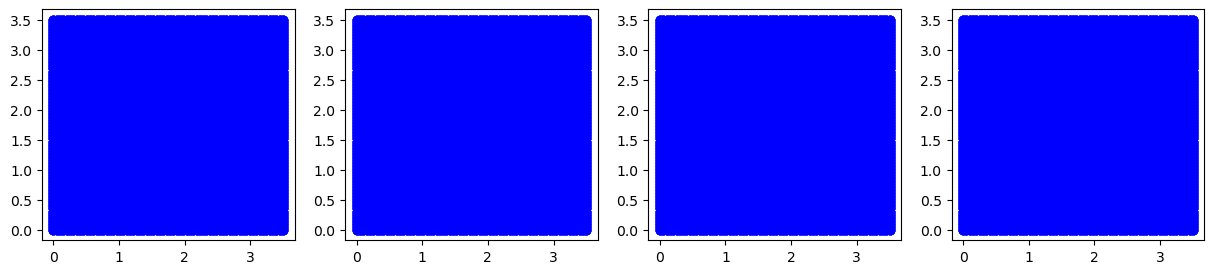

In [22]:
from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, v_branch, t_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [23]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    receiver_size=RECEIVER_SIZE,
    embedding_size=50,
    sensor_branch_layers=[100, 80, 50, 50],
    receiver_branch_layers=4*[50],
    trunk_layers=8*[50],
    root_layers=8*[50],
    actf='tanh'
)

In [24]:
DON.train(dg, epochs=EPOCHS_MAX, verbose=0)
# [x.shape for x in dg[0][0]]

2023-05-20 07:09:57.638774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 07:09:57.639490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 07:09:57.640059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 07:09:57.640999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 07:09:57.641624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

100 - -299.1226463317871s - data updated with vel-ratio = 1.0 
200 - -589.8678362369537s - data updated with vel-ratio = 1.0 
300 - -880.762923002243s - data updated with vel-ratio = 1.0 
400 - -1171.78111577034s - data updated with vel-ratio = 1.0 
500 - -1461.643902540207s - data updated with vel-ratio = 1.0 
600 - -1749.1586875915527s - data updated with vel-ratio = 1.0 
700 - -2037.9624178409576s - data updated with vel-ratio = 1.0 
800 - -2328.5960931777954s - data updated with vel-ratio = 1.0 
900 - -2617.705009460449s - data updated with vel-ratio = 1.0 
1000 - -2905.948397874832s - data updated with vel-ratio = 1.0 
1100 - -3196.268240213394s - data updated with vel-ratio = 1.0 
1200 - -3485.715897321701s - data updated with vel-ratio = 1.0 
1300 - -3771.984697341919s - data updated with vel-ratio = 1.0 
1400 - -4060.6914780139923s - data updated with vel-ratio = 1.0 
1500 - -4348.9794409275055s - data updated with vel-ratio = 1.0 
1600 - -4637.089102983475s - data updated with

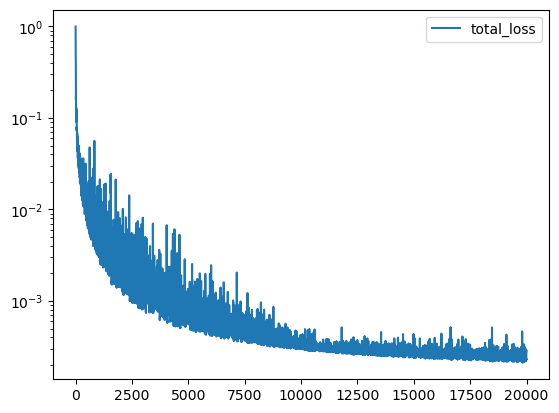

In [25]:
DON.plot_loss()

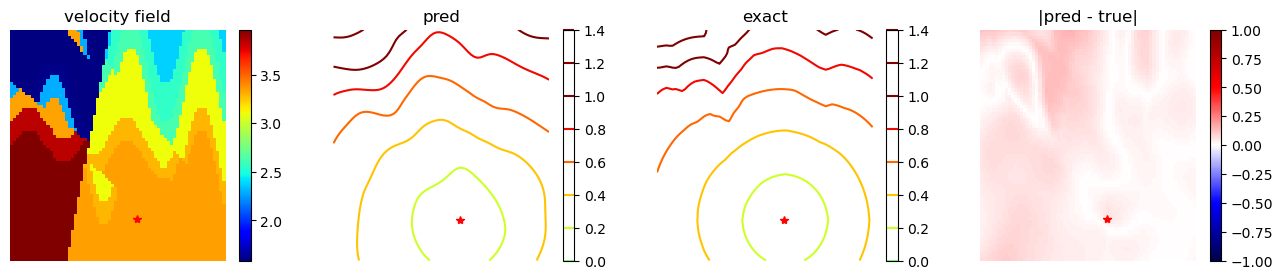

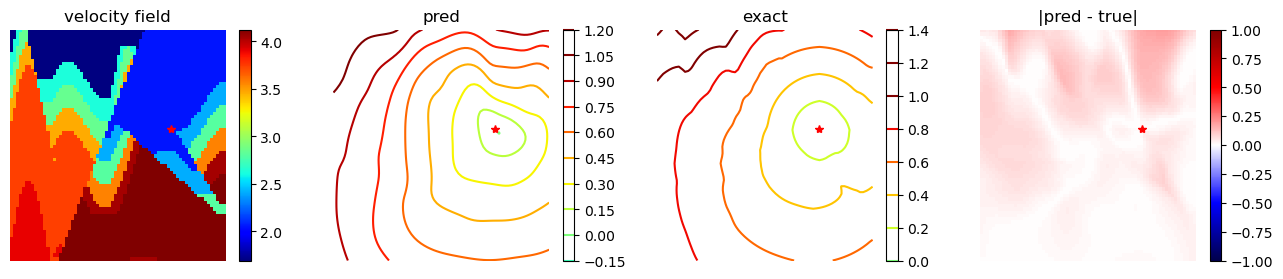

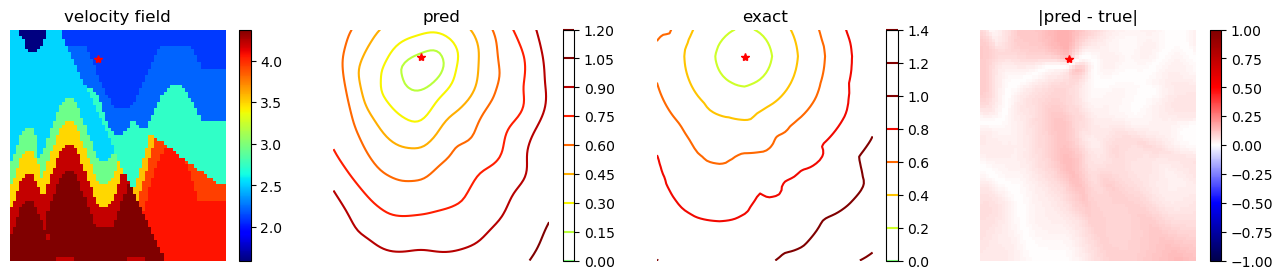

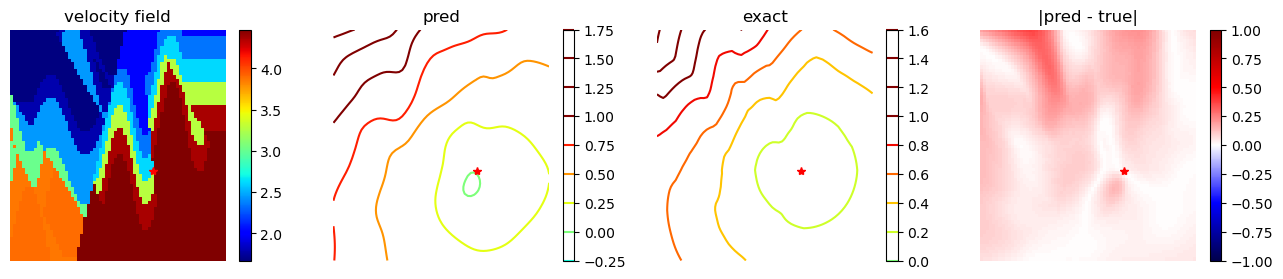

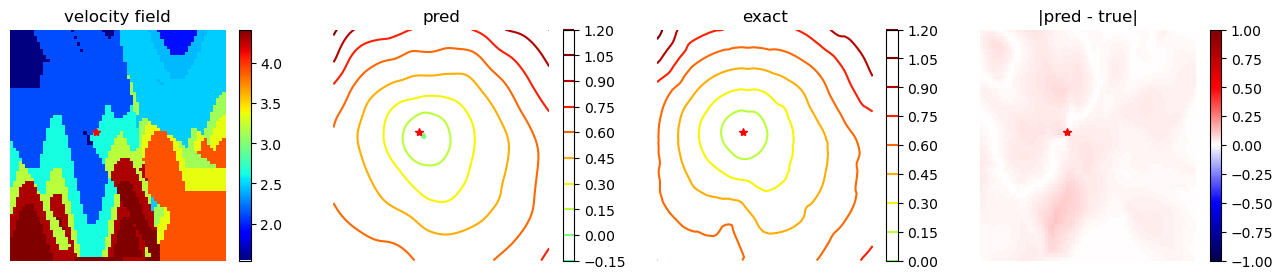

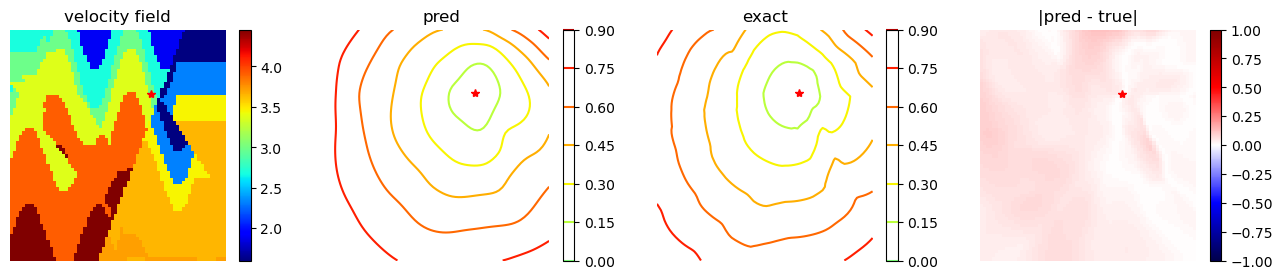

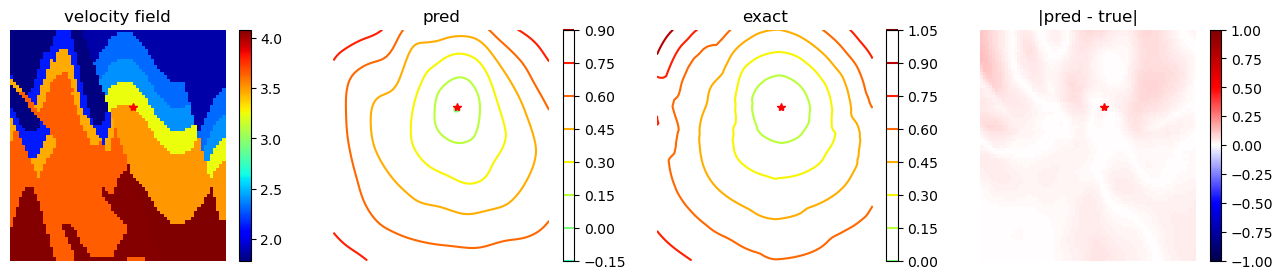

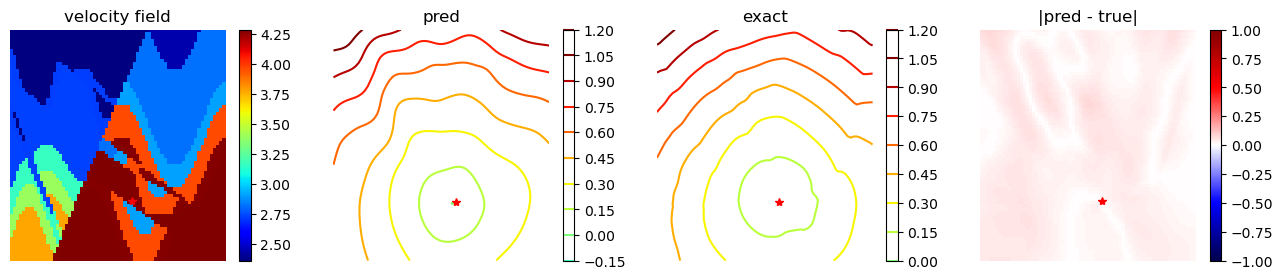

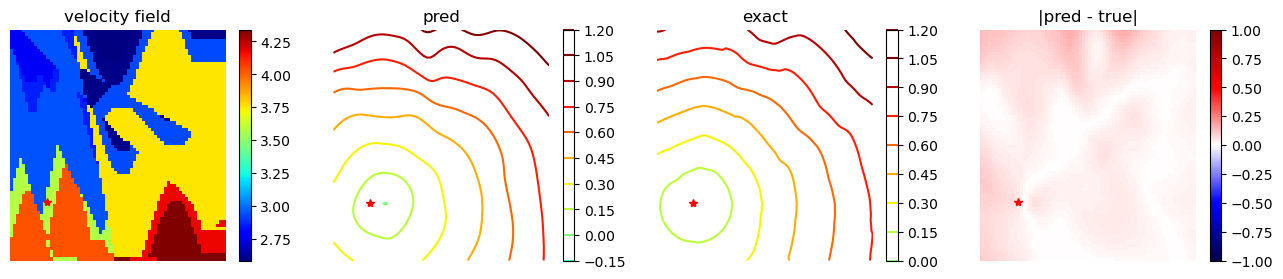

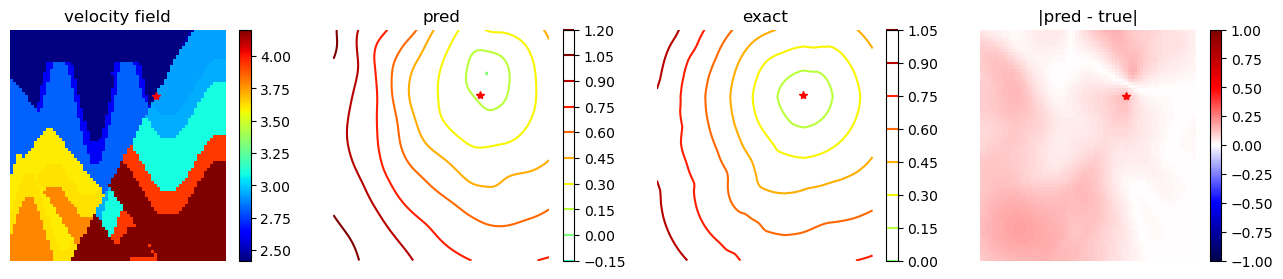

In [26]:
Nx, Ny = 70, 70

for i in range(10):
    velocity = vel_models[300 + i, 0]
    x_source = np.random.uniform(XMIN+0.1*DELTAX, XMAX-0.1*DELTAX)
    y_source = np.random.uniform(YMIN+0.1*DELTAY, YMAX-0.1*DELTAY)
    
    test_data, vel_data, target_data = dg.generate_test_data(x_source, y_source, velocity, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = np.copy(velocity)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    
    ax0 = ax[0].pcolor(x_test, y_test, v_test.T, cmap='jet')
    ax[0].set_title('velocity field')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    
    ax1 = ax[1].contour(x_test, y_test, pred.T, cmap='jet', vmin=-1, vmax=1)
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact.T, cmap='jet', vmin=-1, vmax=1)
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact).T, cmap='seismic', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    for ax_i in ax:
        ax_i.invert_yaxis()
        ax_i.plot(y_source, x_source, '*r')
    
    plt.show()